In [1]:
from math import floor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [2]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [3]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [4]:
env.P[0,:,0]

array([0.85, 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [5]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(env,Q, state, epsilon=0.1, rg=rg):
    if not Q[int(state/(env.num_cols)), state%(env.num_cols)].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
    else:
        return np.argmax(Q[int(state/(env.num_cols)), state%(env.num_cols)])

# Softmax
def choose_action_softmax(env,Q, state, rg=rg, temp=1):
    return rg.choice(Q.shape[-1], p = softmax(Q[int(state/(env.num_cols)), state%(env.num_cols)] / temp))

In [6]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))

alpha = 0.4
gamma = 0.9
epsilon = 0.1
timesteps = 100
episodes = 10000

In [9]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
def plot_Q(Q, message = "Q plot"):
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()
from IPython.display import clear_output
clear_output(wait=True)

In [10]:
print_freq = 100
from tqdm import tqdm

def sarsa(env,Q,gamma,choose_action,plot_heat = False,max_timesteps=100) :
  episode_rewards = []
  state_visit_count = np.zeros((env.num_rows, env.num_cols))
  steps_to_completion = []
  steps = 0

  # start temp
  temp = 1e20
  t_grad = 0.99

  for steps in tqdm(range(episodes)) :
    timesteps=0
    env.reset()
    current_state = env.start_state_seq[0]
    current_action = choose_action(env,Q,current_state)
    rewards = []
    tot_reward = 0 
    while timesteps<max_timesteps :
      timesteps+=1
      next_state,reward = env.step(current_state,current_action)
      next_action = choose_action(env,Q,next_state)
      Q[int(current_state/(env.num_cols)), current_state%(env.num_cols), current_action] += alpha*(reward + gamma*Q[int(next_state/(env.num_cols)), next_state%(env.num_cols), next_action] - Q[int(current_state/(env.num_cols)), current_state%(env.num_cols), current_action])
      rewards.append(reward[0])
      tot_reward = tot_reward + reward[0]
      if reward == env.r_goal :
        break
      current_state = next_state
      current_action = next_action
      state_visit_count[int(current_state/(env.num_cols)), current_state%(env.num_cols)]+=1
    episode_rewards.append(tot_reward)
    steps_to_completion.append(timesteps)
    temp = temp * t_grad

    if (steps+1)%print_freq == 0 and plot_heat:
      clear_output(wait=True)
      plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f, Temp: %.2f"%(steps+1, np.mean(episode_rewards[steps-print_freq+1:steps]),
                                                                           np.mean(steps_to_completion[steps-print_freq+1:steps]),
                                                                           Q.max(), Q.min(), temp))
  return Q, episode_rewards, steps_to_completion,state_visit_count

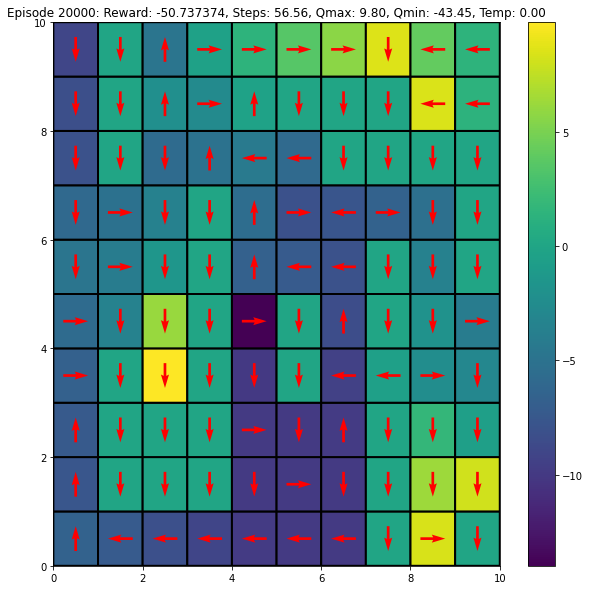

100%|██████████| 20000/20000 [03:45<00:00, 88.87it/s] 


In [9]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))

alpha = 0.4
gamma = 0.9
epsilon = 0.1
timesteps = 100
episodes = 20000

Q,episode_rewards,steps_to_completion,state_visit_count = sarsa(env, Q, gamma = gamma, choose_action= choose_action_softmax,plot_heat = True)

In [10]:
print(state_visit_count)

[[1.58130e+04 2.16260e+04 2.71410e+04 3.48000e+04 4.41240e+04 5.04630e+04
  5.46200e+04 0.00000e+00 2.69900e+03 0.00000e+00]
 [1.18060e+04 0.00000e+00 0.00000e+00 0.00000e+00 4.73670e+04 5.35540e+04
  6.04350e+04 0.00000e+00 3.51100e+03 2.97300e+03]
 [9.30600e+03 0.00000e+00 0.00000e+00 0.00000e+00 4.32530e+04 5.66870e+04
  7.58320e+04 0.00000e+00 2.95500e+03 4.74100e+03]
 [7.45800e+03 0.00000e+00 5.86600e+03 0.00000e+00 1.68290e+04 0.00000e+00
  1.59791e+05 6.00000e+00 4.78400e+03 6.96000e+03]
 [4.72500e+03 4.73200e+03 5.97900e+03 0.00000e+00 1.98800e+03 0.00000e+00
  6.87990e+04 0.00000e+00 7.83700e+03 3.83200e+03]
 [2.45900e+03 3.48800e+03 5.02500e+03 0.00000e+00 1.60510e+04 2.71330e+04
  3.98660e+04 0.00000e+00 1.08050e+04 0.00000e+00]
 [1.35800e+03 2.61400e+03 5.55600e+03 0.00000e+00 2.35850e+04 1.56340e+04
  2.31950e+04 1.81010e+04 1.37570e+04 0.00000e+00]
 [6.67000e+02 0.00000e+00 4.37400e+03 1.30890e+04 1.49190e+04 2.00600e+03
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]


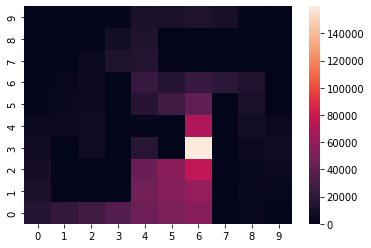

In [11]:
import seaborn as sns
plot = sns.heatmap(state_visit_count)
plot.invert_yaxis()

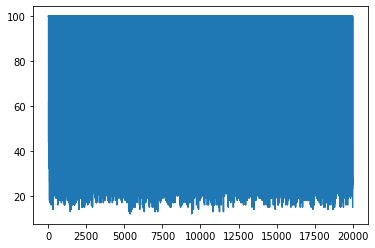

In [12]:
plt.plot(steps_to_completion)

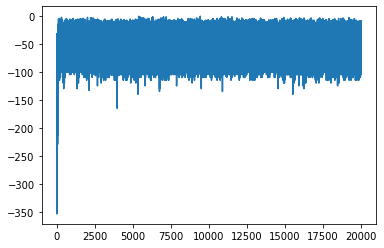

In [13]:
plt.plot(episode_rewards)

In [17]:
Q_avgs, reward_avgs, steps_avgs = [], [], []
alpha = 0.4
gamma = 0.9
epsilon = 0.1
timesteps = 100
episodes = 2000
num_expts = 10

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    rg = np.random.RandomState(i)
    Q, rewards, steps, _ = sarsa(env, Q,gamma,choose_action = choose_action_softmax)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

Experiment: 1


100%|██████████| 2000/2000 [00:19<00:00, 101.05it/s]


Experiment: 2


100%|██████████| 2000/2000 [00:19<00:00, 101.86it/s]


Experiment: 3


100%|██████████| 2000/2000 [00:21<00:00, 94.21it/s] 


Experiment: 4


100%|██████████| 2000/2000 [00:20<00:00, 99.80it/s] 


Experiment: 5


100%|██████████| 2000/2000 [00:19<00:00, 103.62it/s]


Experiment: 6


100%|██████████| 2000/2000 [00:17<00:00, 114.38it/s]


Experiment: 7


100%|██████████| 2000/2000 [00:13<00:00, 149.44it/s]


Experiment: 8


100%|██████████| 2000/2000 [00:11<00:00, 169.02it/s]


Experiment: 9


100%|██████████| 2000/2000 [00:12<00:00, 162.24it/s]


Experiment: 10


100%|██████████| 2000/2000 [00:12<00:00, 158.42it/s]


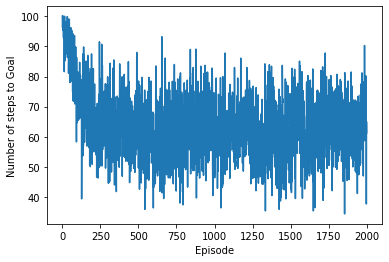

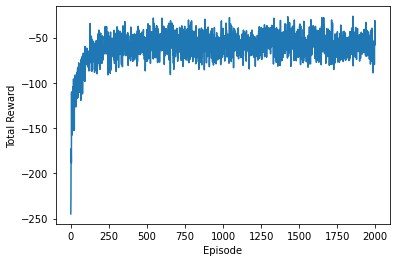

In [18]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

In [13]:
def q_learning(env,Q,gamma,choose_action,plot_heat = False,max_timesteps=100) :
  episode_rewards = []
  state_visit_count = np.zeros((env.num_rows, env.num_cols))
  steps_to_completion = []
  steps = 0
  while steps < episodes :
    timesteps=0
    env.reset()
    current_state = env.start_state_seq[0]
    current_action = choose_action(env,Q,current_state)
    rewards = []
    tot_reward = 0 
    while timesteps<max_timesteps :
      timesteps+=1
      next_state,reward = env.step(current_state,current_action)
      next_action = choose_action(env,Q,next_state)

      # best next action
      best_next_action = np.argmax(Q[next_state//env.num_rows,next_state%env.num_cols])
      Q[int(current_state/(env.num_cols)), current_state%(env.num_cols), current_action] += alpha*(reward + gamma*Q[int(next_state/(env.num_cols)), next_state%(env.num_cols), best_next_action] - Q[int(current_state/(env.num_cols)), current_state%(env.num_cols), current_action])
      rewards.append(reward[0])
      tot_reward = tot_reward + reward[0]
      # print(reward)
      if reward == env.r_goal :
        break
      # print(current_state)
      current_state = next_state
      current_action = next_action
      state_visit_count[int(current_state/(env.num_cols)), current_state%(env.num_cols)]+=1
    episode_rewards.append(tot_reward)
    steps_to_completion.append(timesteps)
    steps+=1

    if (steps+1)%10 == 0 and plot_heat:
      clear_output(wait=True)
      plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(steps+1, np.mean(episode_rewards[steps-10+1:steps]),
                                                                           np.mean(steps_to_completion[steps-10+1:steps]),
                                                                           Q.max(), Q.min()))
  return Q, episode_rewards, steps_to_completion,state_visit_count

In [14]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))

alpha = 0.4
gamma = 0.9
epsilon = 0.1
timesteps = 100
episodes = 10000

In [15]:
Q,episode_rewards,steps_to_completion,state_visit_count = q_learning(env, Q, gamma = gamma, choose_action= choose_action_softmax,plot_heat = True)

KeyboardInterrupt: 

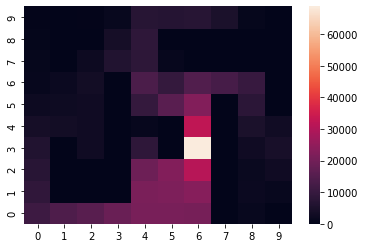

In [ ]:
import seaborn as sns
plot = sns.heatmap(state_visit_count)
plot.invert_yaxis()

In [ ]:
Q_avgs, reward_avgs, steps_avgs = [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    rg = np.random.RandomState(i)
    Q, rewards, steps, _ = q_learning(env, Q,gamma,choose_action = choose_action_softmax)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

Experiment: 1
Experiment: 2
Experiment: 3
Experiment: 4
Experiment: 5


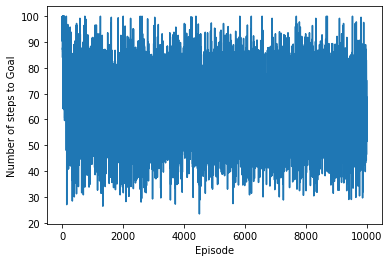

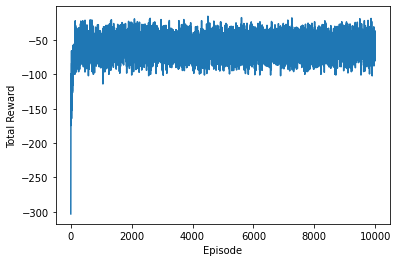

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

In [16]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(env,Q, state, hyper=0.1, rg=rg):
    if not Q[int(state/(env.num_cols)), state%(env.num_cols)].any() or rg.rand() < hyper:
        return rg.choice(Q.shape[-1])
    else:
        return np.argmax(Q[int(state/(env.num_cols)), state%(env.num_cols)])

# Softmax
def choose_action_softmax(env,Q, state, rg=rg, hyper=1):
    return rg.choice(Q.shape[-1], p = softmax(Q[int(state/(env.num_cols)), state%(env.num_cols)] / hyper))

In [40]:
from tqdm import tqdm

def q_learning(env,Q,gamma,alpha,epsilon,choose_action,plot_heat = False,max_timesteps=100) :
  episode_rewards = []
  state_visit_count = np.zeros((env.num_rows, env.num_cols))
  steps_to_completion = []
  steps = 0
  for steps in tqdm(range(episodes)):
    timesteps=0
    env.reset()
    current_state = env.start_state_seq[0]
    current_action = choose_action(env,Q,current_state,hyper=epsilon)
    rewards = []
    tot_reward = 0 
    while timesteps<max_timesteps :
      timesteps+=1
      next_state,reward = env.step(current_state,current_action)
      next_action = choose_action(env,Q,next_state, hyper=epsilon)

      # best next action
      best_next_action = np.argmax(Q[next_state//env.num_rows,next_state%env.num_cols])
      Q[int(current_state/(env.num_cols)), current_state%(env.num_cols), current_action] += alpha*(reward + gamma*Q[int(next_state/(env.num_cols)), next_state%(env.num_cols), best_next_action] - Q[int(current_state/(env.num_cols)), current_state%(env.num_cols), current_action])
      rewards.append(reward[0])
      tot_reward = tot_reward + reward[0]
      # print(reward)
      if reward == env.r_goal :
        break
      # print(current_state)
      current_state = next_state
      current_action = next_action
      state_visit_count[int(current_state/(env.num_cols)), current_state%(env.num_cols)]+=1
    episode_rewards.append(tot_reward)
    steps_to_completion.append(timesteps)

    if (steps+1)%10 == 0 and plot_heat:
      clear_output(wait=True)
      plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(steps+1, np.mean(episode_rewards[steps-10+1:steps]),
                                                                           np.mean(steps_to_completion[steps-10+1:steps]),
                                                                           Q.max(), Q.min()))
  return Q, episode_rewards, steps_to_completion,state_visit_count

In [45]:
def eval_Q(env,Q, max_timesteps=100) :
    episode_rewards = []
    steps_to_completion = []
    steps = 0
    episodes = 100
    for steps in tqdm(range(episodes)):
        timesteps=0
        env.reset()
        current_state = env.start_state_seq[0]
        current_action = np.argmax(Q[int(current_state/(env.num_cols)), current_state%(env.num_cols)])
        rewards = []
        tot_reward = 0 
        while timesteps<max_timesteps :
            timesteps+=1
            next_state,reward = env.step(current_state,current_action)
            next_action = np.argmax(Q[int(next_state/(env.num_cols)), next_state%(env.num_cols)])

            rewards.append(reward[0])
            tot_reward = tot_reward + reward[0]
            # print(reward)
            if reward == env.r_goal :
                break
            # print(current_state)
            current_state = next_state
            current_action = next_action
        episode_rewards.append(tot_reward)
        steps_to_completion.append(timesteps)

    return np.mean(episode_rewards)

In [47]:
'''
conf 1
wind = False
start state = [0,4]
p = 1.0
strategy = e_greedy
'''

wind = False
start_state = [0,4]
p = 1.0

# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([start_state])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = wind)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

# hyper parameter set
alphas = np.linspace(0.1,0.9,9)
gammas = np.linspace(0.5,0.9,5)
epsilons = [0,0.01,0.1]
episodes = 20000

# tune hyperparameters
from math import inf
seed = 42
opt_alpha = 1
opt_gamma = 1
opt_epsilon = 0.1
max_valuation = -inf
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
            rg = np.random.RandomState(seed)
            Q, rewards, steps, _ = q_learning(env, Q,gamma,alpha,epsilon,choose_action = choose_action_epsilon)
            valuation = eval_Q(env,Q)
            if(valuation > max_valuation):
                opt_alpha = alpha
                opt_gamma = gamma
                opt_epsilon = epsilon
                max_valuation = valuation
            
print(opt_alpha,opt_gamma, opt_epsilon)

100%|██████████| 100/100 [00:00<00:00, 2272.53it/s]

0.1 0.5 0


In [48]:
'''
conf 1
wind = False
start state = [0,4]
p = 1.0
strategy = e_greedy
'''

wind = False
start_state = [0,4]
p = 1.0

# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([start_state])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = wind)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

# hyper parameter set
alphas = np.linspace(0.1,0.9,9)
gammas = np.linspace(0.5,0.9,5)
epsilons = [0,0.01,0.1]
episodes = 10000

# tune hyperparameters
from math import inf
seed = 42
opt_alpha = 1
opt_gamma = 1
opt_epsilon = 0.1
max_valuation = -inf
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
            rg = np.random.RandomState(seed)
            Q, rewards, steps, _ = q_learning(env, Q,gamma,alpha,epsilon,choose_action = choose_action_epsilon)
            valuation = eval_Q(env,Q)
            if(valuation > max_valuation):
                opt_alpha = alpha
                opt_gamma = gamma
                opt_epsilon = epsilon
                max_valuation = valuation
            
print(opt_alpha,opt_gamma, opt_epsilon)

100%|██████████| 100/100 [00:00<00:00, 2499.99it/s]

0.1 0.5 0


In [ ]:
import multiprocessing as mp

'''
conf 1
wind = False
start state = [0,4]
p = 1.0
strategy = e_greedy
'''

wind = False
start_state = [0,4]
p = 1.0

# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([start_state])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = wind)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

# hyper parameter set
alphas = np.linspace(0,1,10)
gammas = np.linspace(0.5,1,5)
epsilons = [0,0.01,0.1]
episodes = 10000

# tune hyperparameters
from math import inf
seed = 42
opt_alpha = 1
opt_gamma = 1
opt_epsilon = 0.1
max_rew = -inf

# before we tune, create a pool to dive in
pool = mp.Pool()
input = []
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
            # rg = np.random.RandomState(seed)
            # Q, rewards, steps, _ = q_learning(env, Q,gamma,alpha,epsilon,choose_action = choose_action_epsilon)
            input.append((env, Q, alpha, epsilon, choose_action_epsilon))
            # rew = np.mean(rewards[episodes-100:episodes])
            # if(rew > max_rew):
            #     opt_alpha = alpha
            #     opt_epsilon = epsilon
            #     opt_gamma = gamma
            #     max_rew = rew
            
# print(input)
rg = np.random.RandomState(seed)
results = pool.imap(q_learning, input)
            
# print(opt_alpha,opt_gamma, opt_epsilon)
print("; ".join(results))
# print(input.__len__())

In [49]:
'''
conf 1
wind = False
start state = [0,4]
p = 1.0
strategy = e_greedy
'''

wind = False
start_state = [0,4]
p = 1.0

# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([start_state])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = wind)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

Q_avgs, reward_avgs, steps_avgs = [], [], []
num_expts = 3

alpha = 0.1
gamma = 0.5
epsilon = 0
episodes = 10000

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    rg = np.random.RandomState(i)
    Q, rewards, steps, _ = q_learning(env, Q,gamma,alpha,epsilon,choose_action = choose_action_epsilon)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)
    
print("Convergence of rewards approx. ", np.mean(np.average(reward_avgs,axis=0)[episodes-10:episodes]))
print("Convergence of time steps approx. ", np.mean(np.average(steps_avgs,axis=0)[episodes-10:episodes]))

Experiment: 1


100%|██████████| 10000/10000 [00:07<00:00, 1255.34it/s]


Experiment: 2


100%|██████████| 10000/10000 [00:07<00:00, 1300.89it/s]


Experiment: 3


100%|██████████| 10000/10000 [00:07<00:00, 1298.99it/s]

Convergence of rewards approx.  -6.0
Convergence of time steps approx.  17.0


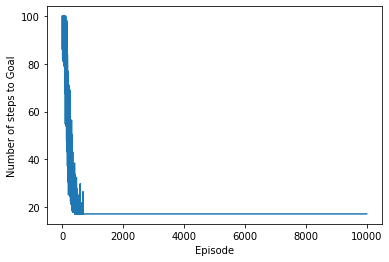

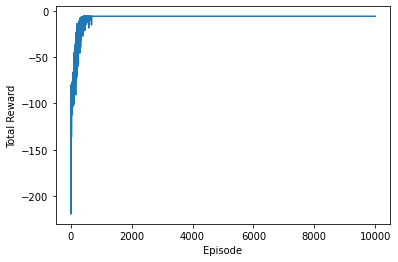

In [50]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()